Logs 
- [2023/05/14]   
  The first version of this notebook. Please restart this notebook
  if there is a modification to the file `forecast.py`

  Implementation of manual estimation of MA(2) params 
  ($\mu$, $\omega_1$, $\omega_2$, $\sigma_\epsilon$) is not easy.
  Some useful references:
  - (Brockwell and Davis, 2016) - Introduction  to Time Series and 
    Forecasting, 3rd Ed. Chapter 5
    Hannan-Rissanen algorithm and Inovative algorithm
    are suitable for a pure moving-average models

  - (Box et al, 2016) - Time Series Analysis - Forecasting and Control, 
    5th Ed.

# Example 8.2 - MA(2) model

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import lmfit
import tabulate
import scipy.optimize as sc_optimize

sys.path.append(os.path.abspath(os.path.join("..")))

from lib.forecast import Forecast as fcast


from statsmodels.tsa.arima.model import ARIMA

In [4]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

## Load data

### Atron process

In [5]:
filename = "08-table-05-atron-process.ods"

df = fcast.read_ods(filename)

header_names = df.columns.to_list()
process_arr = []
for header in header_names:
  process_arr += df[header].to_list()

process_arr = np.array(process_arr)
process_arr = process_arr[~np.isnan(process_arr)]
df = pd.DataFrame()
df["t"] = np.arange(1, len(process_arr) + 1, dtype=int)
df["Y_t"] = process_arr

df["Y_tM1"] = df["Y_t"].shift(1)
df["Y_tM2"] = df["Y_t"].shift(2)

# display(process_arr)
df

,t,Y_t,Y_tM1,Y_tM2
0,1,60.0,NaN,NaN
1,2,81.0,60.0,NaN
2,3,72.0,81.0,60.0
3,4,78.0,72.0,81.0
4,5,61.5,78.0,72.0
...,...,...,...,...
70,71,90.0,73.5,87.0
71,72,78.0,90.0,73.5
72,73,87.0,78.0,90.0
73,74,99.0,87.0,78.0


### Plot of the data

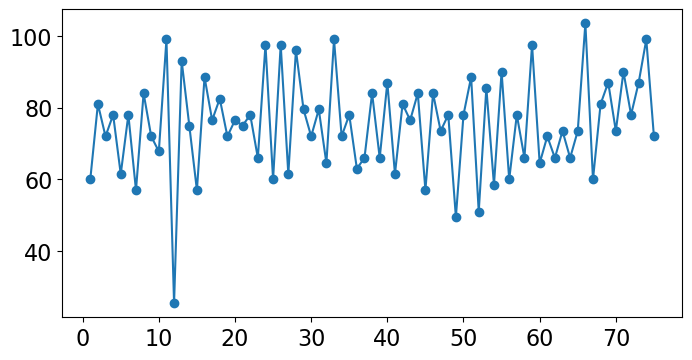

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=6)

plt.show(fig)

## MA(2) model

$$
  Y_t = \mu + \varepsilon_t 
          - \omega_1 \varepsilon_{t-1} - \omega_2 \varepsilon_{t-2}
$$

$\mu$, $\omega_1$, and $\omega_2$ are estimated parameters

In [43]:
def obj_func(params, y_data):
  mu = params[0]
  omega1 = params[1]
  omega2 = params[2]
  sigma_sq = params[3]

  n_data = len(y_data)
  epsilon_arr = np.zeros(2 + n_data)
  # epsilon_arr[:2] = [0.5, 0.5]   # We don't know this initial value
  for t in range(n_data):
    epsilon = y_data[t] - mu + omega1 * epsilon_arr[t+1] \
                              + omega2 * epsilon_arr[t]
    epsilon_arr[t+2] = epsilon

  epsilon_arr = epsilon_arr[2:]   # cut epsilon_{-1} and epsilon_0

  # -- log-likelihood (see the formula in xournal++ note
  #    chapter-08-2023-05-14-Note-09-07.xopp. In the note, we
  #    describe the log-likelihood function for MA(1).
  #    In her we compute for MA(2) and try to minimize (multiply
  #    log-likelihood by -1)

  return n_data*np.log(2.*np.pi)/2 + n_data*np.log(sigma_sq)/2 \
    + (epsilon_arr**2/(2.*sigma_sq)).sum()



In [46]:
def get_estimated_params(df, params_init):
  y_data = df["Y"].to_numpy()

  optimize_out = sc_optimize.least_squares(obj_func, params_init, 
    args=(y_data, ), ftol=1e-14)

  return optimize_out.x

In [49]:
params_init = [75., 0.55, -0.35, 130]
df_least_sq = df[["t", "Y_t"]]
df_least_sq = df_least_sq.rename(columns={"Y_t": "Y"})
# df_least_sq
get_estimated_params(df_least_sq, params_init)

array([ 75.38104428,   0.55421311,  -0.33968501, 130.01997668])

## Using `statsmodels`

In [9]:
Y_t = df["Y_t"].to_numpy()
Y_t

array([ 60. ,  81. ,  72. ,  78. ,  61.5,  78. ,  57. ,  84. ,  72. ,
        67.8,  99. ,  25.5,  93. ,  75. ,  57. ,  88.5,  76.5,  82.5,
        72. ,  76.5,  75. ,  78. ,  66. ,  97.5,  60. ,  97.5,  61.5,
        96. ,  79.5,  72. ,  79.5,  64.5,  99. ,  72. ,  78. ,  63. ,
        66. ,  84. ,  66. ,  87. ,  61.5,  81. ,  76.5,  84. ,  57. ,
        84. ,  73.5,  78. ,  49.5,  78. ,  88.5,  51. ,  85.5,  58.5,
        90. ,  60. ,  78. ,  66. ,  97.5,  64.5,  72. ,  66. ,  73.5,
        66. ,  73.5, 103.5,  60. ,  81. ,  87. ,  73.5,  90. ,  78. ,
        87. ,  99. ,  72. ])

In [52]:
model = ARIMA(Y_t, order=(0, 0, 2))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   75
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -289.335
Date:                Sun, 14 May 2023   AIC                            586.670
Time:                        21:35:18   BIC                            595.940
Sample:                             0   HQIC                           590.371
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.4099      1.056     71.407      0.000      73.340      77.480
ma.L1         -0.5581      0.120     -4.643      0.000      -0.794      -0.323
ma.L2          0.3455      0.128      2.697      0.0